In [54]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [55]:
df = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df.shape[0])
print("Número de variables: %d" % df.shape[1])
if df.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


In [56]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [57]:
process_cadastral(df)

In [58]:
df = df.dropna()

In [59]:
X = df.drop(columns=['CLASE']).copy()
y = df['CLASE'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=10)

df_modelar = X_train.merge(y_train, on='ID')
df_modelar_new = X_val.merge(y_val, on='ID')

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  87728
Tamaño del conjunto de nuevos datos:  15482


In [60]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

## Distancia al centro

In [61]:
center_x = df_modelar['X'].sum()/len(df_modelar['X'])
center_y = df_modelar['Y'].sum()/len(df_modelar['Y'])

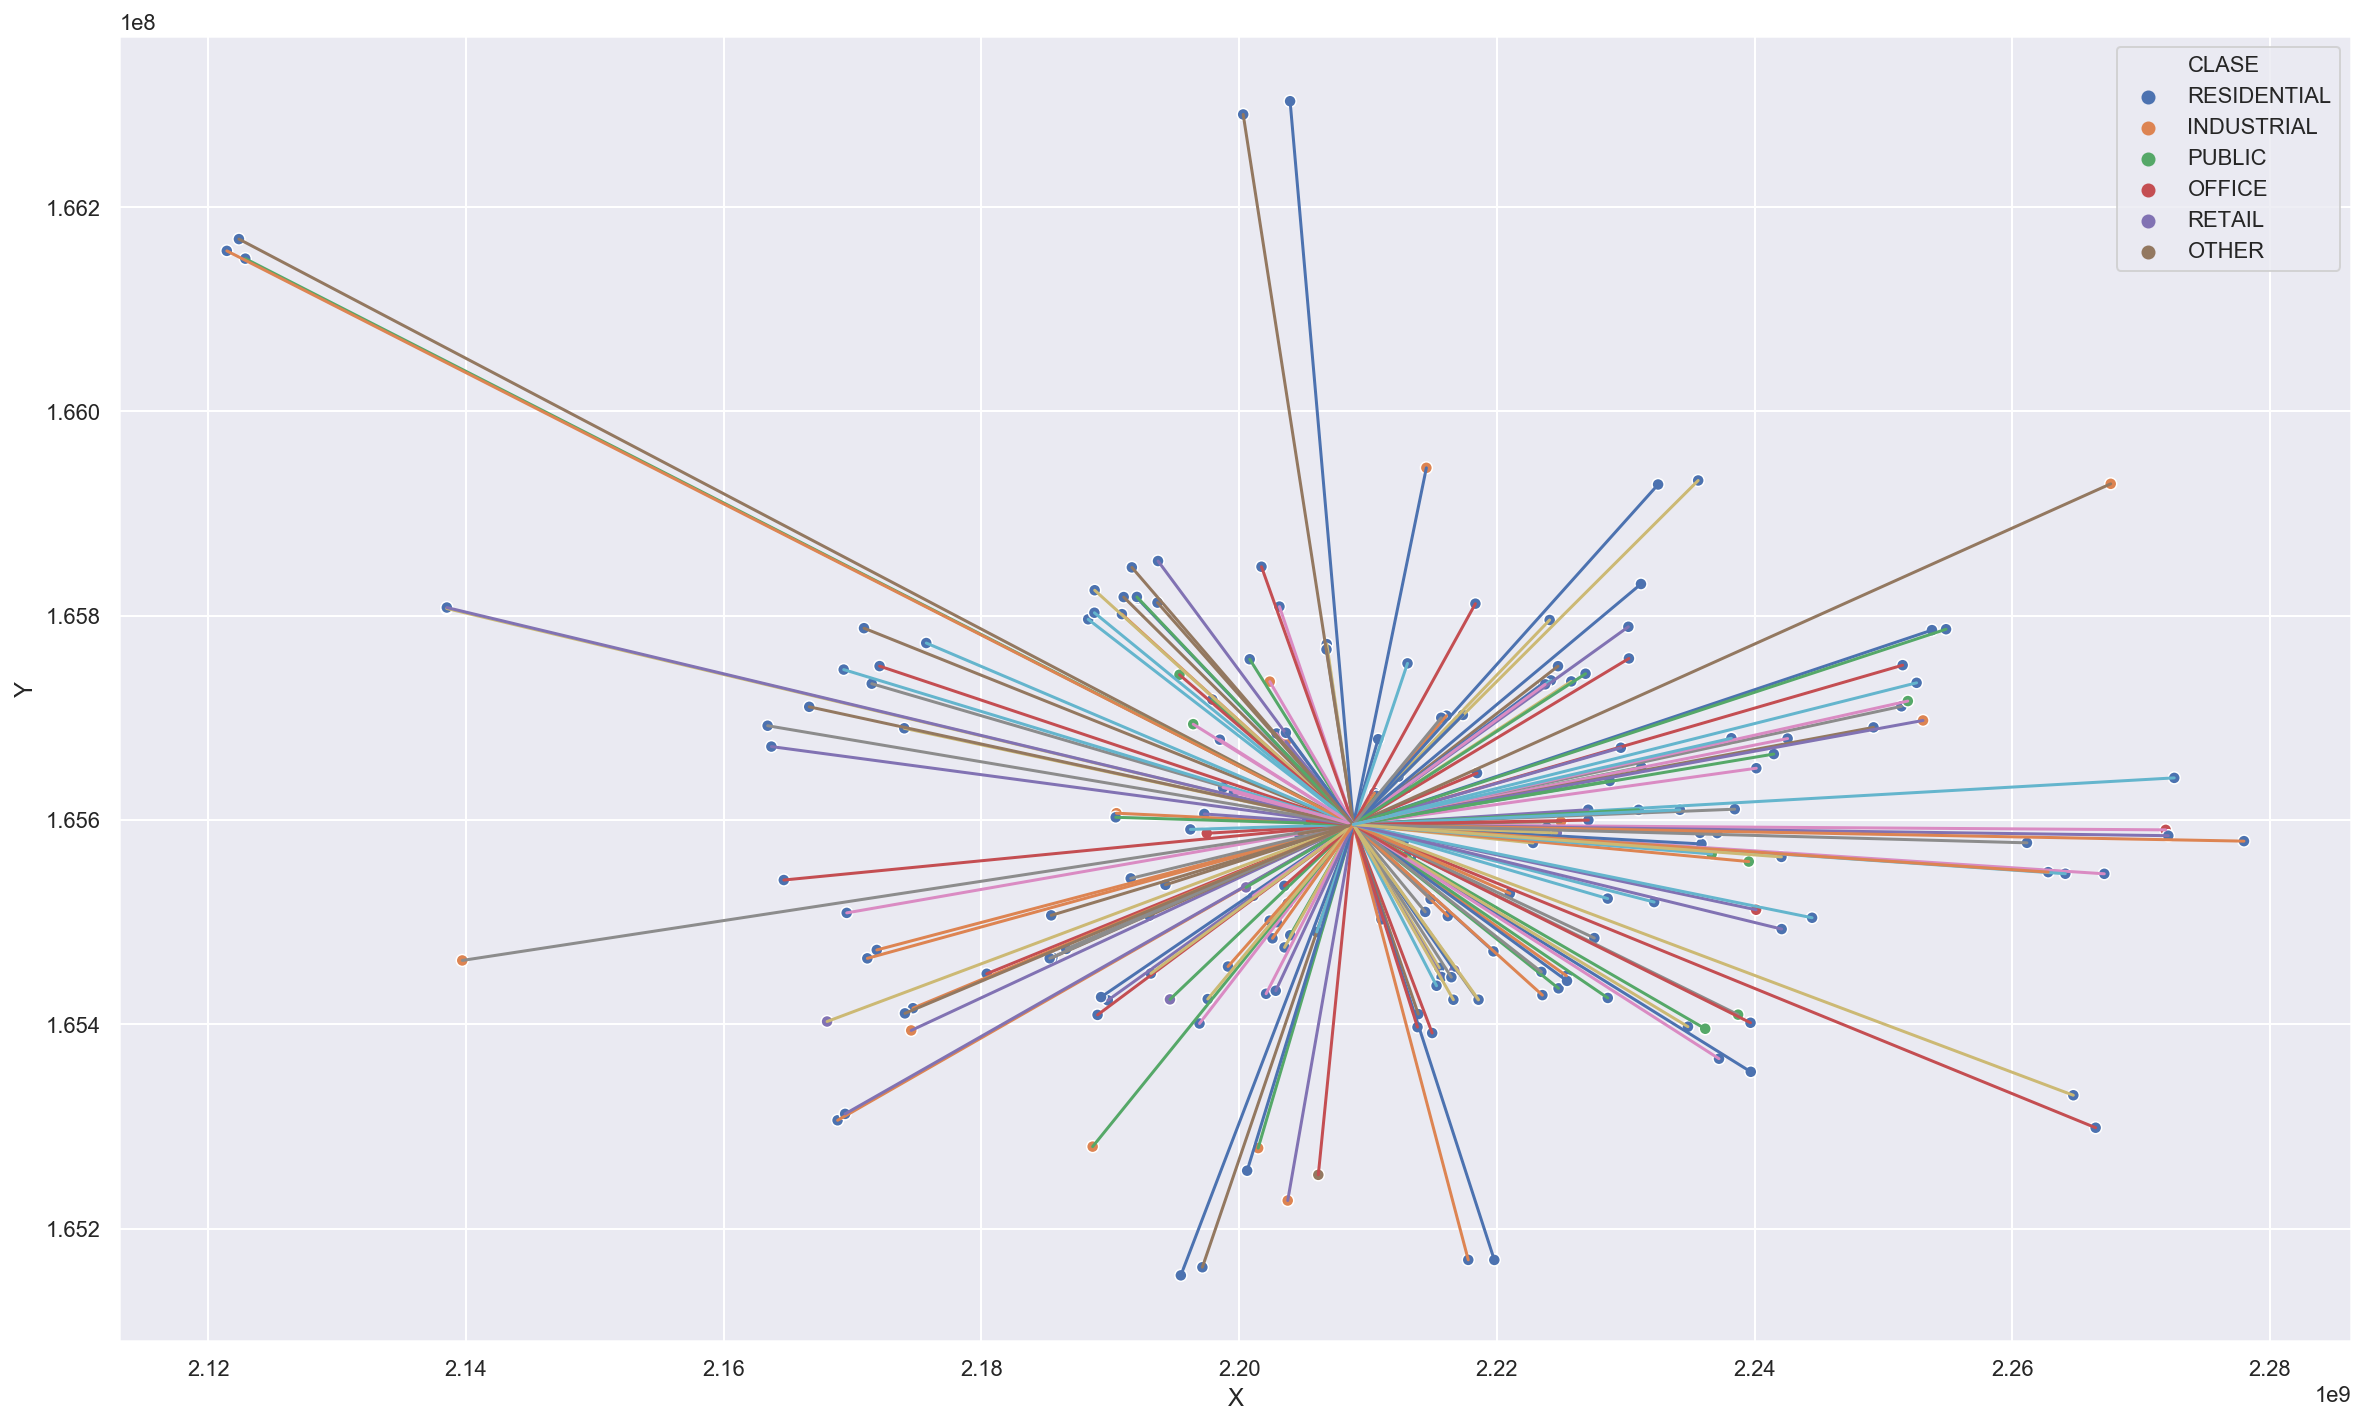

In [62]:
plt.figure(figsize=(20,12))
for i in range(200):
    point1 = [df_modelar.iloc[i]['X'], df_modelar.iloc[i]['Y']]
    point2 = [center_x, center_y]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values)
sns.scatterplot(df_modelar['X'][:200], df_modelar['Y'][:200], hue=df_modelar['CLASE'][:200])

In [63]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

In [64]:
df_modelar['distance_to_center'] = df_modelar.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)

In [65]:
df_modelar['distance_to_center'] = df_modelar['distance_to_center'] / df_modelar['distance_to_center'].max() #Normalizamos 0,1

In [66]:
df_modelar.groupby('CLASE')['distance_to_center'].mean()

CLASE
AGRICULTURE    0.348430
INDUSTRIAL     0.372862
OFFICE         0.183858
OTHER          0.213616
PUBLIC         0.226200
RESIDENTIAL    0.230438
RETAIL         0.230114
Name: distance_to_center, dtype: float64

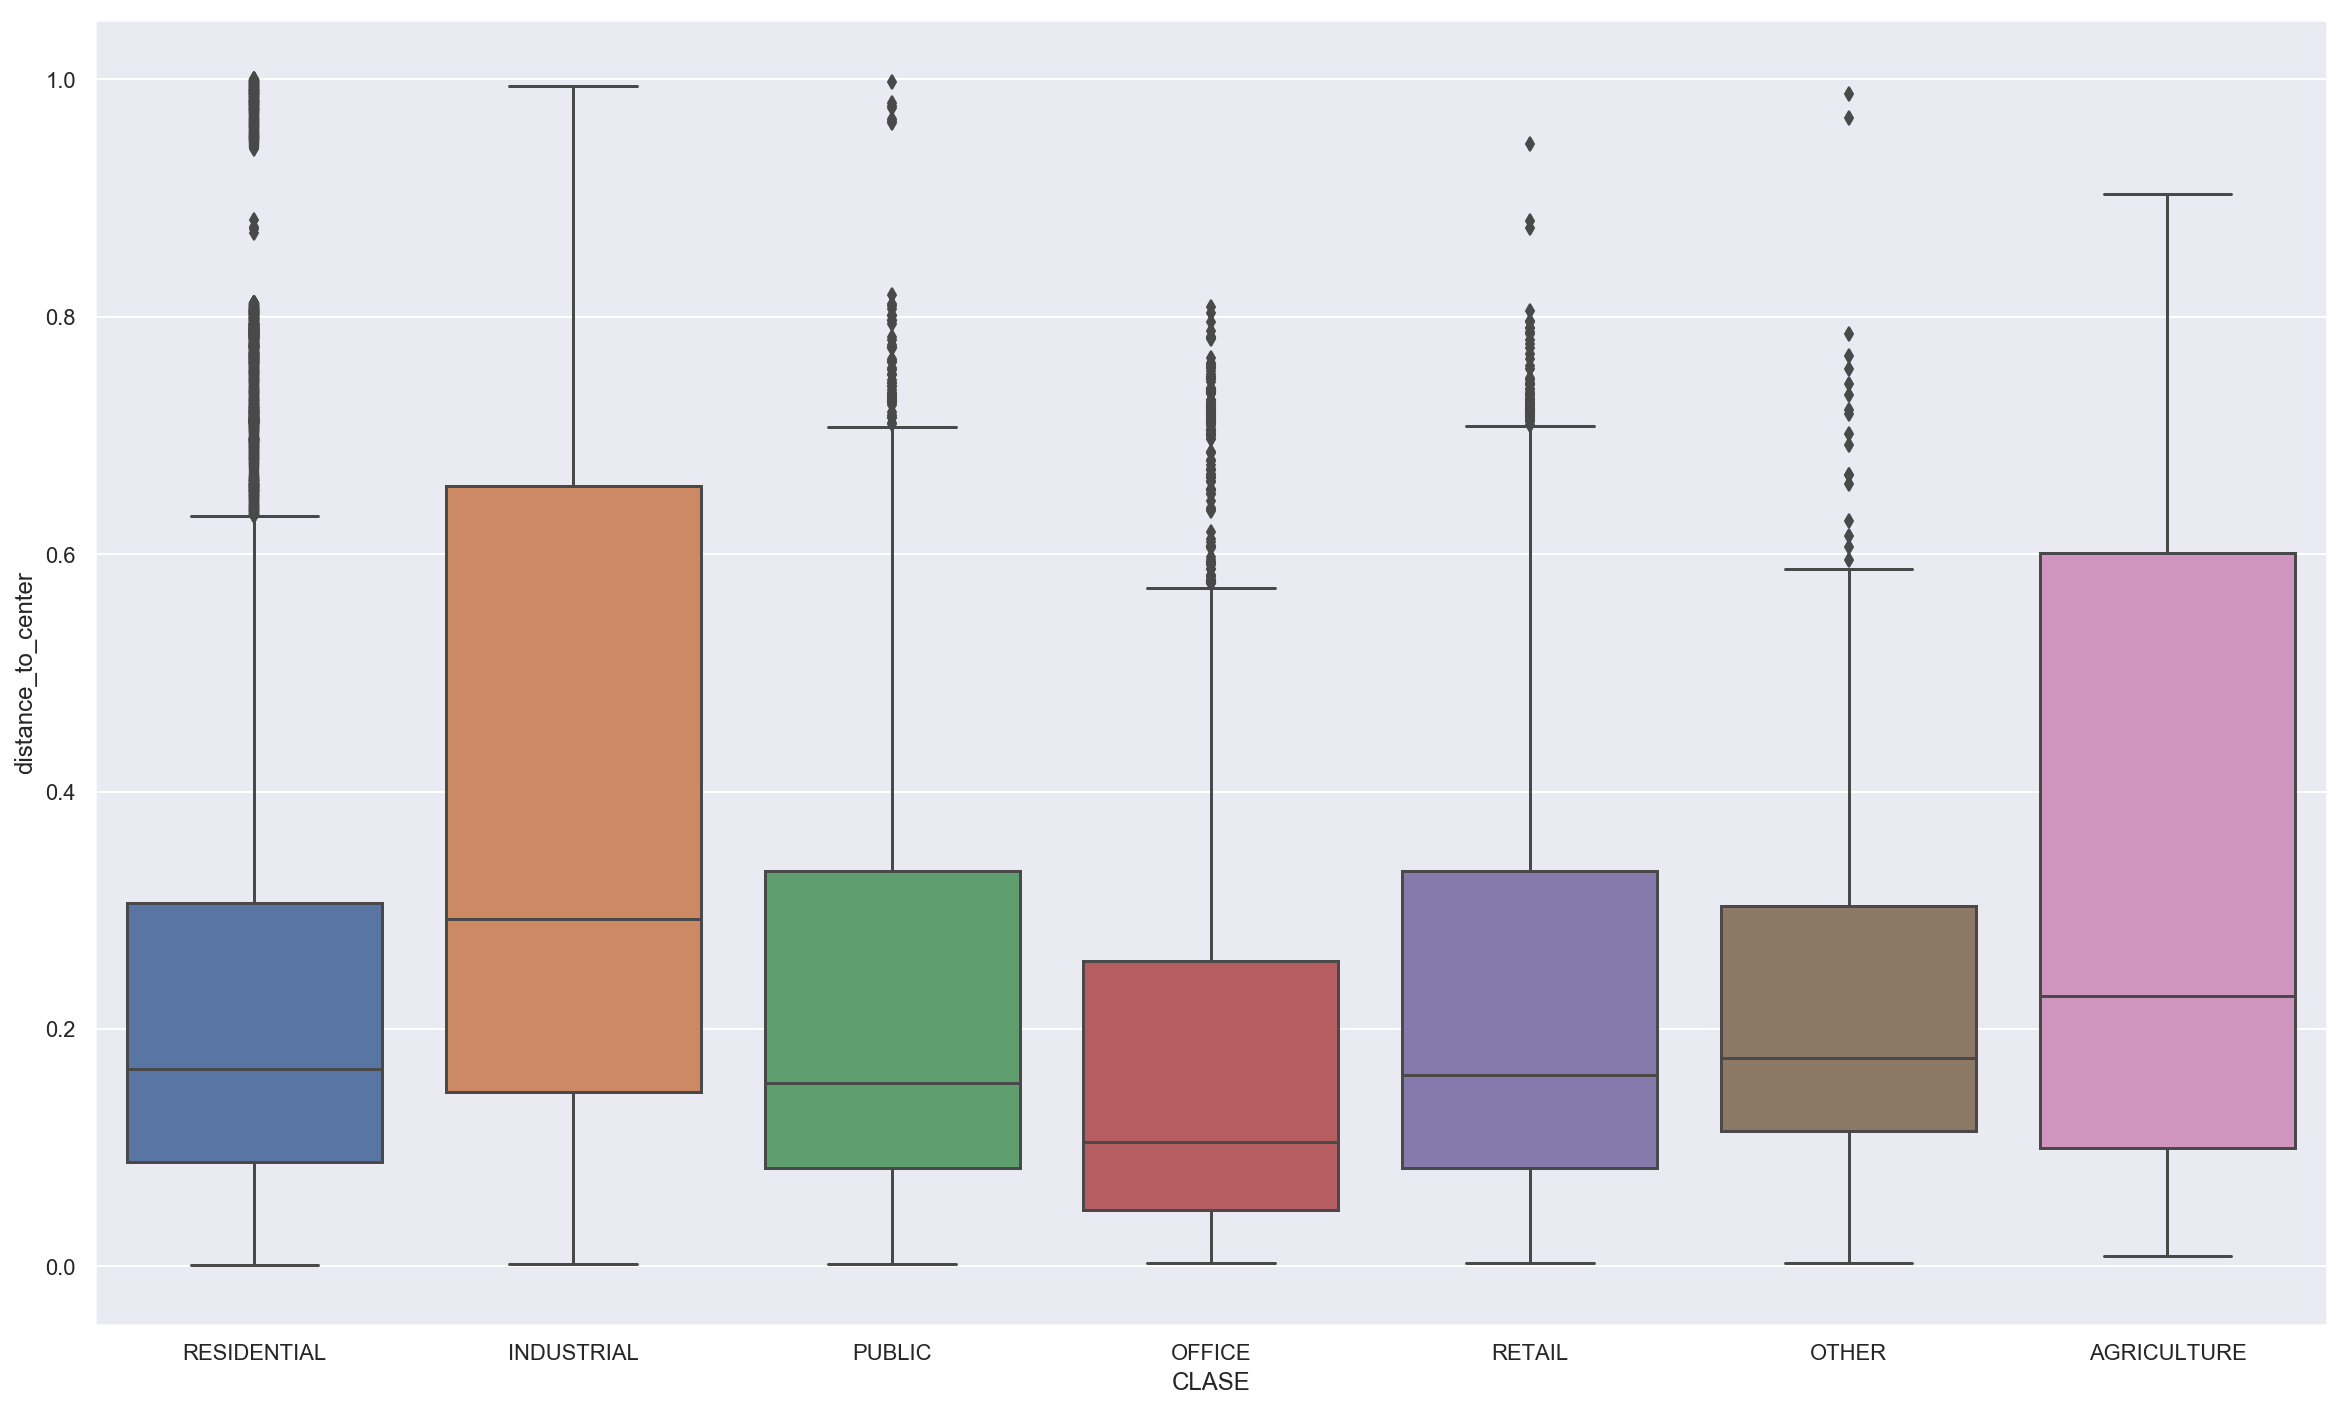

In [67]:
plt.figure(figsize=(20,12))
sns.boxplot(x="CLASE", y="distance_to_center", data=df_modelar)

## Densidad de vecinos

In [68]:
from sklearn.neighbors import KNeighborsClassifier

X = df_modelar[df_modelar.CLASE!= 'RESIDENTIAL'][['X', 'Y']].copy()
y = df_modelar[df_modelar.CLASE!= 'RESIDENTIAL']['CLASE'].copy()

w = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [ ]:
for n in range(1, 15):
    neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
    neigh.fit(X, y)
    predictKNN = neigh.predict(X_test)
    w.append(accuracy_score(y_test, predictKNN))
             

Text(0,0.5,'Accuracy')

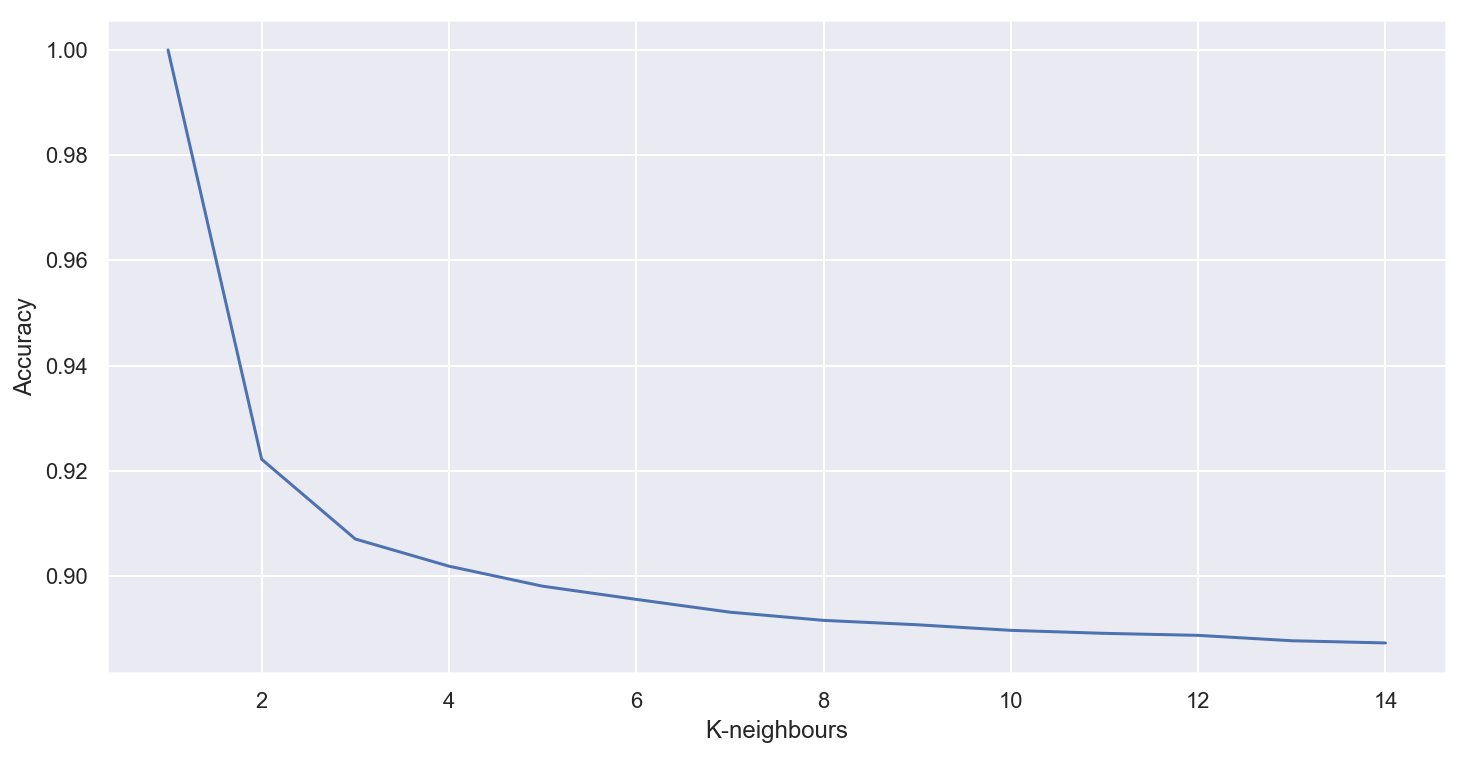

In [23]:
plt.figure(figsize=(12,6))
plt.plot(range(1,15), w)
plt.xlabel('K-neighbours')
plt.ylabel('Accuracy');

Como podemos observar si elegiesemos k con valor a 1, estaríamos obteniendo un 1 de accuracy, es decir, no estaríamos fallando en la predicción. Dado que lo que nos interesa es conocer el entorno del registro, no nos vale con un k relativamente pequeño como puede ser 1 o 2. Sin embargo, para poder conocer mejor el entorno del registro a predecir, podemos observar que a partir del valor 5, dejamos de disminuir el accuracy, por lo que creemos que es un valor lo suficientemente representativo del entorno y no sacrificamos demasiado el accuracy. Lo que nos interesa con este proceso no es obtener una clasificación de 1 y no fallar, lo que nos interesa es obtener más registros alrededor de nuestra predicción que nos aporte información con respecto a la situación en la que está. Por ejemplo, si estuviese en el centro la probabilidad de los vecinos a que sean Residenciales serían de 1, mientra que si estuviese a las afueras quizás tendría 2 vecinos residenciales y 3 industriales. Por lo que ello, creemos que le puede aportar mayor información al modelo.

In [69]:
n = 5
neigh = KNeighborsClassifier(n_neighbors=n, weights='uniform')
neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
y_pred = neigh.predict(X_test)
y_prob = neigh.predict_proba(X_test)

In [71]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.71      0.65      0.68        82
  INDUSTRIAL       0.66      0.82      0.73      1144
      OFFICE       0.57      0.48      0.52       466
       OTHER       0.48      0.48      0.48       340
      PUBLIC       0.59      0.55      0.57       759
      RETAIL       0.63      0.45      0.52       534

    accuracy                           0.61      3325
   macro avg       0.61      0.57      0.58      3325
weighted avg       0.61      0.61      0.60      3325



In [72]:
aux = pd.DataFrame(y_prob*n, columns=neigh.classes_, index=X_test.index)

In [73]:
aux_2 = X_test.merge(aux, on='ID', how='inner')

In [74]:
aux_2[neigh.classes_].sum()

AGRICULTURE     315.0
INDUSTRIAL     5737.0
OFFICE         2344.0
OTHER          1750.0
PUBLIC         3701.0
RETAIL         2778.0
dtype: float64

In [21]:
#import pickle
#pickle.dump(neigh, open('./knn_CCG.model', 'wb'))

---

In [75]:
predict = neigh.predict_proba(df_modelar[['X', 'Y']])

In [76]:
aux = pd.DataFrame(predict*n, columns=[ 'C_'+c for c in neigh.classes_ ], index=df_modelar.index)
df_modelar = df_modelar.merge(aux, on='ID', how='inner')

In [78]:
#df_modelar[df_modelar['C_RESIDENTIAL'] == 0].head()

In [79]:
df_modelar.drop(columns=['X', 'Y'], inplace=True)

---

# Colores

In [80]:
df_modelar['mean_red'] = df_modelar.loc[:, 'Q_R_4_0_1':'Q_R_4_1_0'].mean(axis=1)
df_modelar['mean_green'] = df_modelar.loc[:, 'Q_G_3_0_1':'Q_G_3_1_0'].mean(axis=1)
df_modelar['mean_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
df_modelar['mean_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

df_modelar['max_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
df_modelar['max_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
df_modelar['max_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
df_modelar['max_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

df_modelar['min_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
df_modelar['min_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
df_modelar['min_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
df_modelar['min_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

df_modelar['std_red'] = df_modelar.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
df_modelar['std_green'] = df_modelar.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
df_modelar['std_blue'] = df_modelar.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
df_modelar['std_nir'] = df_modelar.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)

In [81]:
df_modelar.drop(columns=df_modelar.columns[0:44], inplace=True)

In [82]:
df_modelar.head()

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,distance_to_center,...,max_blue,max_nir,min_red,min_green,min_blue,min_nir,std_red,std_green,std_blue,std_nir
ID,,,,,,,,,,,,,,,,,,,,,
ED9D46EC9089E51C,69.265483,0.549504,0.086580,0.091630,1.058322,1980,5.0,5.0,RESIDENTIAL,0.021845,...,1940.403140,7092.767616,0.000000e+00,0.000000e+00,193.000626,0.000000e+00,2030.964843,2081.176715,450.052681,1883.124040
F9643836C56CEF97,170.407108,0.497172,0.048519,0.060132,1.239357,1968,5.0,3.0,RESIDENTIAL,0.419746,...,2316.603431,6351.600628,3.225805e-10,5.348288e-11,82.000023,1.416269e-03,1603.946002,1535.972564,588.534171,1579.265904
55C034472ED68EAC,270.463800,0.729586,0.052521,0.051361,0.977915,1968,8.0,5.0,RESIDENTIAL,0.055612,...,2962.301546,6803.875107,1.105847e-06,2.385926e-06,147.000473,1.063087e-05,1918.759030,1812.010385,745.845472,1791.301293
37BA5591BA9128AF,61.612400,0.442987,0.086207,0.083403,0.967473,1985,1.0,6.0,RESIDENTIAL,0.483798,...,1272.582375,7129.170274,2.370434e-06,4.466228e-07,83.000023,9.530236e-07,1351.578182,1261.806214,303.392748,1885.560587
1F0DC2B421224578,10.474800,0.738119,0.228311,0.308642,1.351852,1977,8.0,4.0,INDUSTRIAL,0.389428,...,2008.771165,6412.296193,0.000000e+00,4.331495e-11,38.001034,1.182399e-05,1798.933321,1705.057102,493.664627,1662.112861


In [83]:
df_modelar.corr().style.background_gradient(cmap='coolwarm')

,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,distance_to_center,C_AGRICULTURE,C_INDUSTRIAL,C_OFFICE,C_OTHER,C_PUBLIC,C_RETAIL,mean_red,mean_green,mean_blue,mean_nir,max_red,max_green,max_blue,max_nir,min_red,min_green,min_blue,min_nir,std_red,std_green,std_blue,std_nir
AREA,1,-0.121392,-0.216518,-0.215009,0.00204071,0.0391782,0.16776,0.0198011,0.00366382,-0.00304537,0.00844241,0.0115165,0.0127144,0.00228267,-0.0322598,0.0324276,0.0325279,0.0613065,0.0202553,0.0132604,0.00965724,0.034971,0.00396558,-0.00716908,-0.0019396,-0.0239274,-0.00397042,0.012283,0.00842318,0.035194,0.00295208
GEOM_R1,-0.121392,1,0.349604,0.324004,0.0383859,-0.046715,-0.0087414,0.0389174,-0.0759327,-0.0196128,0.0165031,0.0468032,-0.0439121,-0.0108405,-0.00536287,0.0578501,0.0805731,0.146409,0.0029454,0.0555614,0.085249,0.188746,0.0690337,0.0262451,-0.00309919,0.0504947,-0.049642,0.0552216,0.0852215,0.186388,0.0719247
GEOM_R2,-0.216518,0.349604,1,0.703506,-0.245952,0.024629,-0.275855,-0.114019,0.0147916,0.0440735,0.0194183,-0.0634386,0.0390012,-0.0165795,0.00239785,-0.0474834,-0.0217518,0.0140637,0.0376815,-0.0418007,-0.0215703,0.0518258,-0.0123703,0.0508785,0.0104611,0.00659308,-0.00715973,-0.0419534,-0.0222213,0.0537064,-0.0159238
GEOM_R3,-0.215009,0.324004,0.703506,1,0.359592,0.0281906,-0.272104,-0.109239,0.0182753,0.0355751,0.031731,-0.051391,0.043685,-0.0341181,-0.00500128,-0.00942847,0.00951416,0.0277435,0.0472713,-0.0043498,0.00932775,0.0602015,0.0082225,0.0661269,0.0082334,-0.00253132,-0.00880681,-0.00485089,0.00848512,0.0621256,0.00503318
GEOM_R4,0.00204071,0.0383859,-0.245952,0.359592,1,-0.00408037,0.00136767,-0.00528959,-0.00102027,-0.00243665,0.0201052,0.0169468,4.76377e-05,-0.0244354,-0.0117934,0.0576519,0.0572155,0.0466816,0.0336271,0.0580914,0.0567681,0.0509724,0.049681,0.0118034,-0.0031384,-0.00839225,-0.00178106,0.0577859,0.056564,0.0518076,0.0494145
CONTRUCTIONYEAR,0.0391782,-0.046715,0.024629,0.0281906,-0.00408037,1,-0.208432,0.325,0.323785,0.154704,0.197185,-0.152209,0.0263698,-0.0167259,-0.157955,-0.133344,-0.0936835,-0.029363,0.150641,-0.125131,-0.135728,-0.0207084,-0.115775,0.0975507,-0.00427857,-0.117057,0.0184308,-0.123455,-0.137849,-0.00644557,-0.13327
MAXBUILDINGFLOOR,0.16776,-0.0087414,-0.275855,-0.272104,0.00136767,-0.208432,1,-0.0281515,-0.288542,-0.131462,-0.151703,0.101541,0.0348699,0.014443,0.0914597,0.0993297,0.0632443,0.118431,-0.189455,0.0533454,0.056614,0.053448,0.0238278,-0.114493,0.0269858,0.0817083,-0.0288126,0.0509208,0.0566798,0.038855,0.0416694
CADASTRALQUALITYID,0.0198011,0.0389174,-0.114019,-0.109239,-0.00528959,0.325,-0.0281515,1,0.12941,0.0901579,-0.0352241,0.175589,-0.213424,0.107644,-0.0804015,-0.11183,-0.108339,-0.174988,-0.0157508,-0.0324473,-0.0537672,-0.0958921,-0.0493603,0.0174724,-0.0104776,-0.0714902,0.000984452,-0.0253965,-0.0486078,-0.085562,-0.0520097
distance_to_center,0.00366382,-0.0759327,0.0147916,0.0182753,-0.00102027,0.323785,-0.288542,0.12941,1,0.16389,0.342798,-0.223081,-0.107662,-0.0713485,-0.0996997,-0.0904014,-0.0598691,-0.162555,0.298949,-0.0571748,-0.0937387,-0.131417,-0.070053,-0.00796903,0.00539293,-0.315237,0.0317544,-0.0532662,-0.0945424,-0.0990352,-0.0982646
C_AGRICULTURE,-0.00304537,-0.0196128,0.0440735,0.0355751,-0.00243665,0.154704,-0.131462,0.0901579,0.16389,1,-0.047133,-0.0794571,-0.0970985,-0.055321,-0.0843345,-0.103443,-0.0708051,-0.0909938,0.0872111,-0.0801753,-0.0653123,-0.0443563,-0.0487595,0.0210562,0.0705566,-0.020111,0.156558,-0.0777764,-0.0643022,-0.0352671,-0.0578868


# Modelos

In [84]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, df_modelar.select_dtypes(include=np.number).columns.tolist())])

In [85]:
df_modelar['SUBCLASE'] = (df_modelar['CLASE'] == 'RESIDENTIAL').astype(int)

In [86]:
#Para nuestro primer modelo vamos a usar todas las variables
X = df_modelar.drop(columns=['CLASE', 'SUBCLASE']).copy()
y = df_modelar['SUBCLASE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [87]:
X_train.columns

Index(['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR',
       'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'distance_to_center',
       'C_AGRICULTURE', 'C_INDUSTRIAL', 'C_OFFICE', 'C_OTHER', 'C_PUBLIC',
       'C_RETAIL', 'mean_red', 'mean_green', 'mean_blue', 'mean_nir',
       'max_red', 'max_green', 'max_blue', 'max_nir', 'min_red', 'min_green',
       'min_blue', 'min_nir', 'std_red', 'std_green', 'std_blue', 'std_nir'],
      dtype='object')

In [88]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)
underSampling = RandomUnderSampler('majority', random_state=10)
smote = SMOTE('minority', random_state=10)

parameters = {
    'clas__max_depth': [10],
    'clas__scale_pos_weight': [1]
}

minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('smt', smote), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.4s finished


Mejor score:  0.9581702632070769
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__scale_pos_weight': 1}


In [89]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

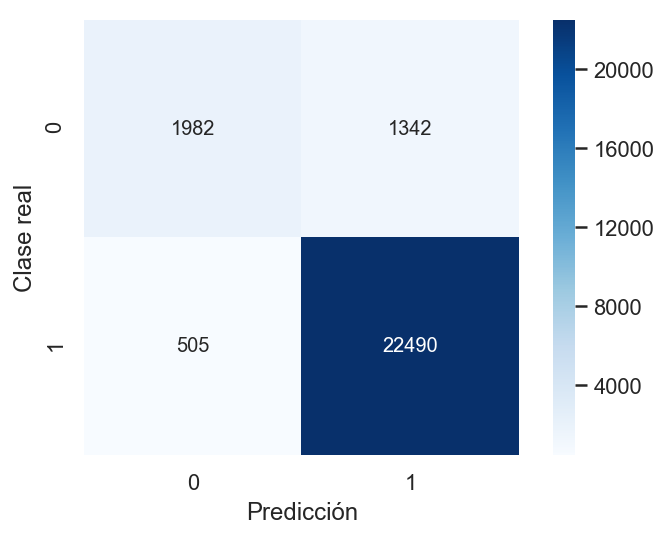

Resultados
Accuracy: 0.93


In [90]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
show_results(y_test, y_pred)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.60      0.68      3324
           1       0.94      0.98      0.96     22995

    accuracy                           0.93     26319
   macro avg       0.87      0.79      0.82     26319
weighted avg       0.93      0.93      0.93     26319



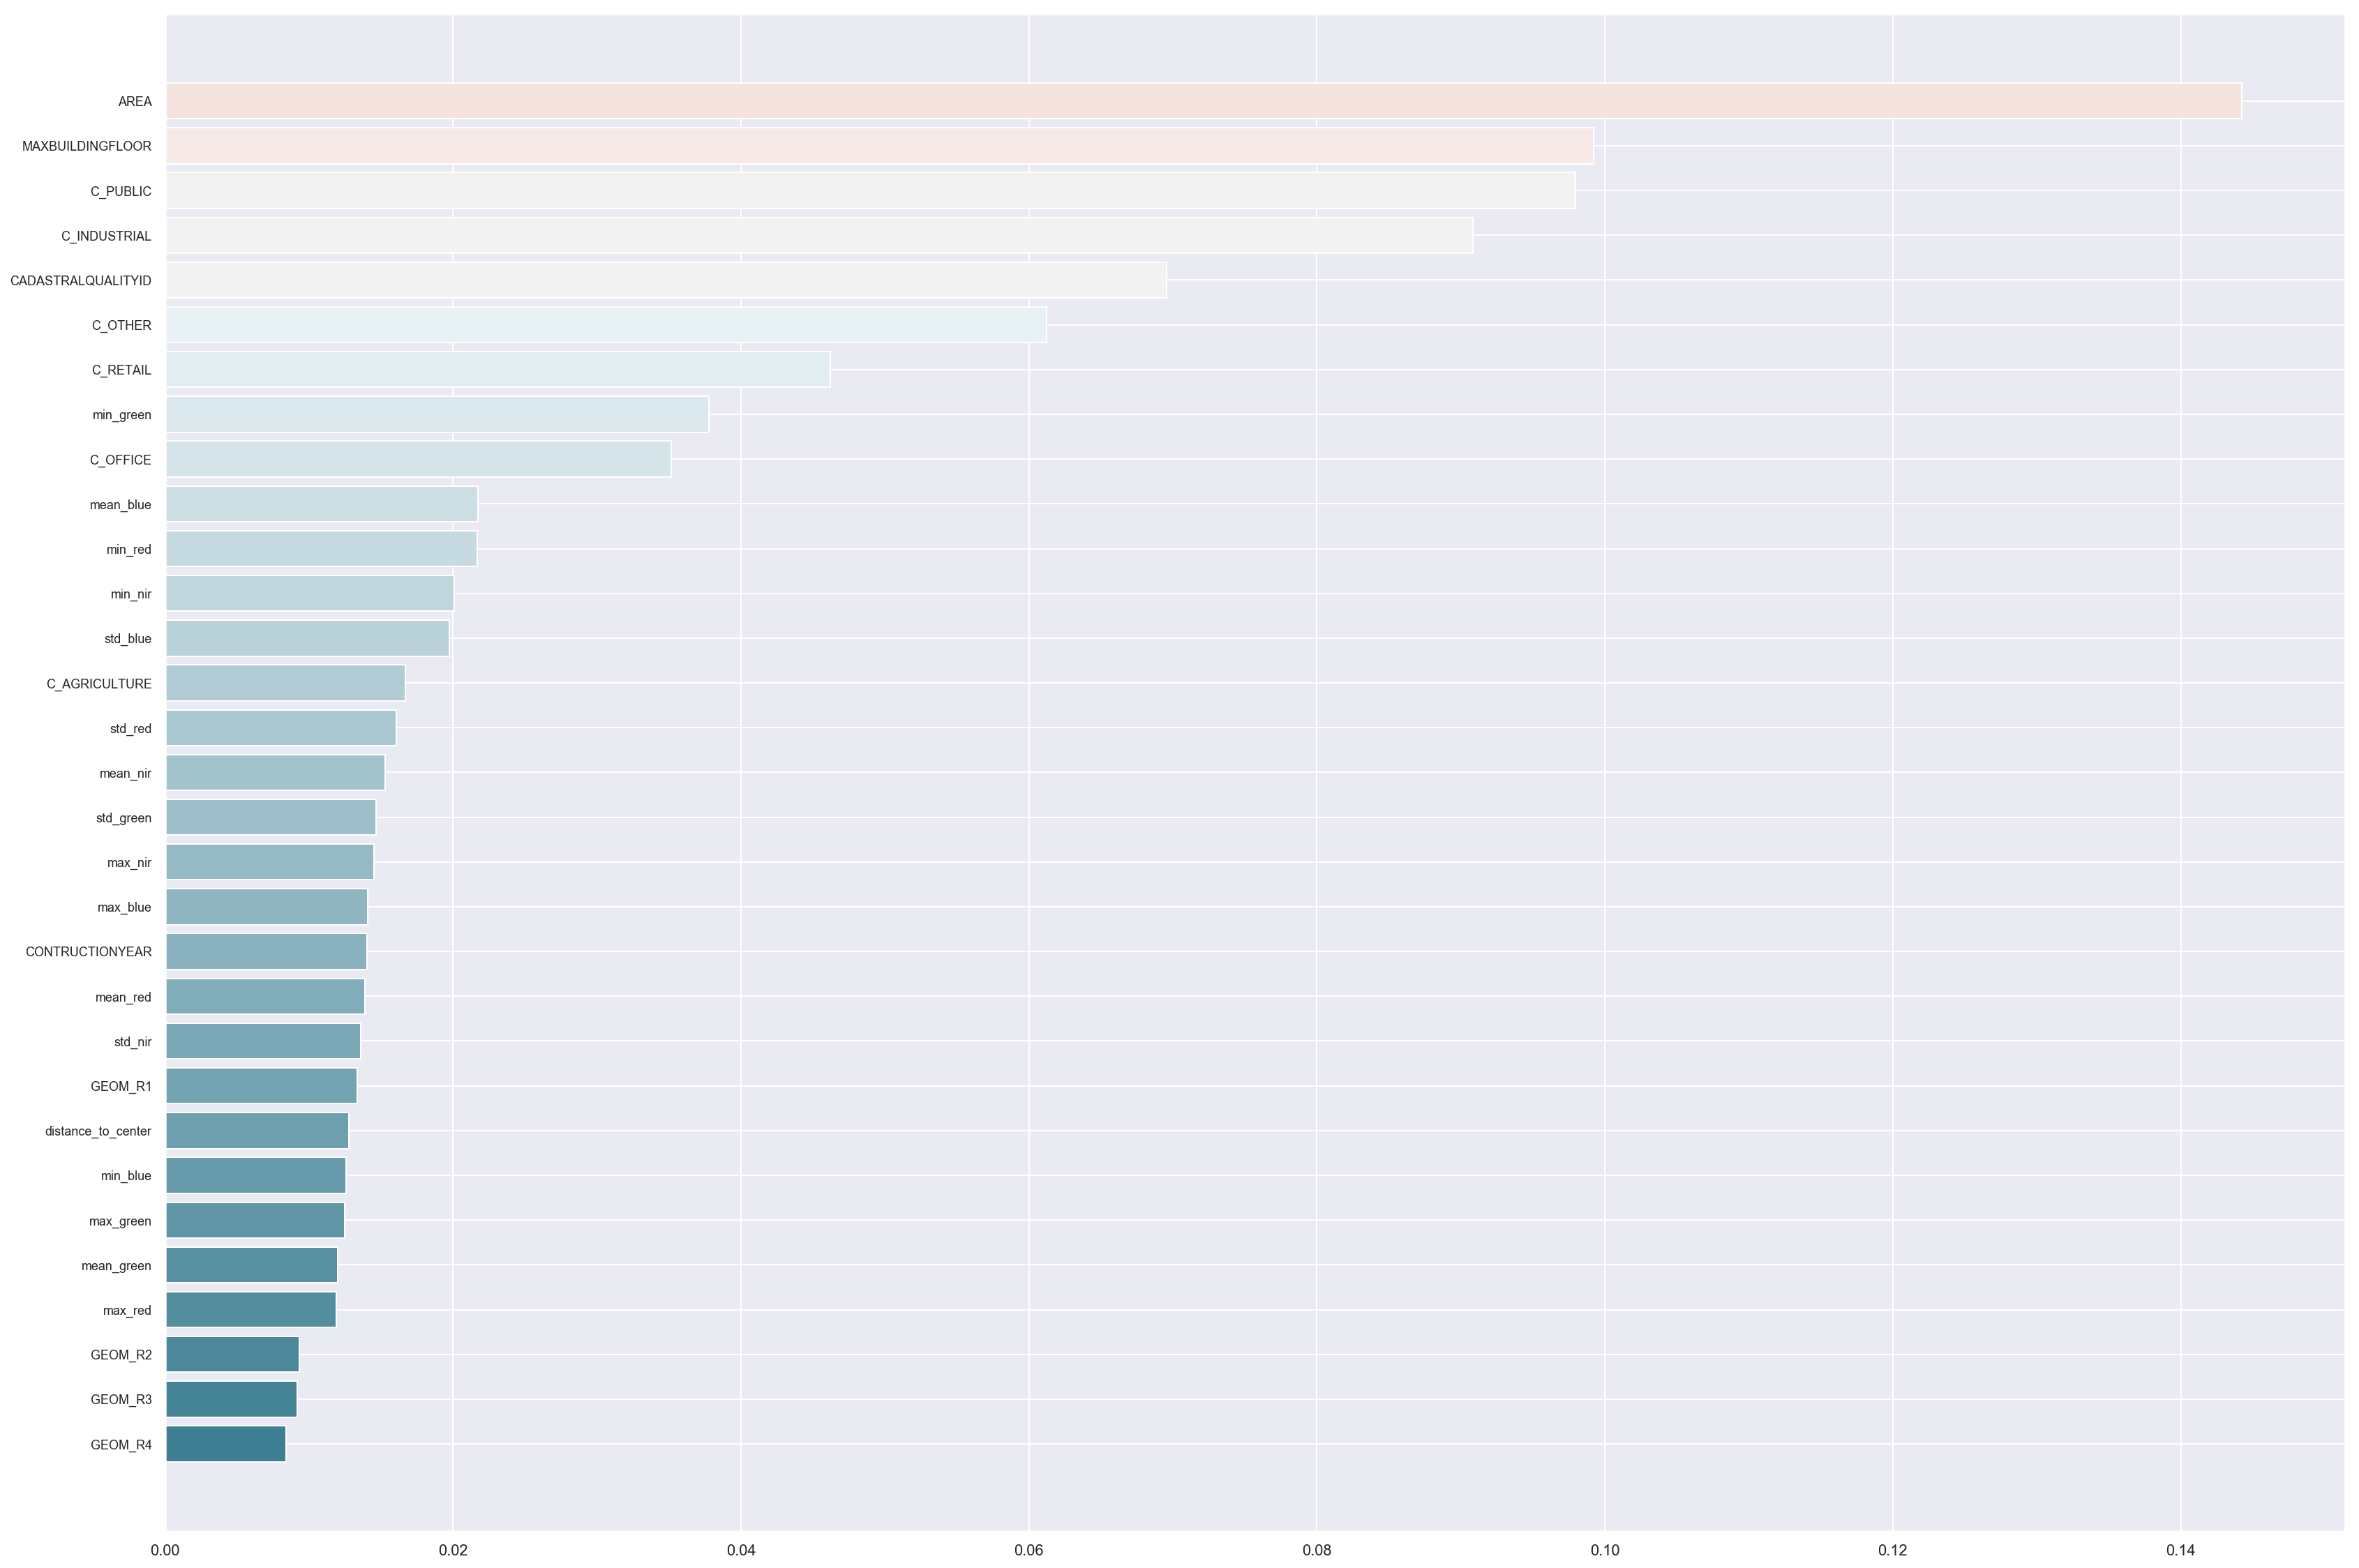

In [92]:
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [93]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('binary_xgboost_CCG.model', 'wb'))

---

# MULTIETIQUETA

In [94]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)

In [95]:
X_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()].drop(columns=['CLASE', 'SUBCLASE']).copy()
y_multi = df_modelar.loc[X_train[y_pred_train==0].index.tolist()]['CLASE'].copy()

In [96]:
y_multi.value_counts()

INDUSTRIAL     2257
PUBLIC         1281
OFFICE          743
RETAIL          704
OTHER           647
RESIDENTIAL     361
AGRICULTURE     183
Name: CLASE, dtype: int64

In [97]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=10)
#smt = SMOTE('not majority', random_state=10)

In [98]:
X_train_multi.columns

Index(['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR',
       'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID', 'distance_to_center',
       'C_AGRICULTURE', 'C_INDUSTRIAL', 'C_OFFICE', 'C_OTHER', 'C_PUBLIC',
       'C_RETAIL', 'mean_red', 'mean_green', 'mean_blue', 'mean_nir',
       'max_red', 'max_green', 'max_blue', 'max_nir', 'min_red', 'min_green',
       'min_blue', 'min_nir', 'std_red', 'std_green', 'std_blue', 'std_nir'],
      dtype='object')

In [99]:
model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [5, 10, 20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                            # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [100, 200]
parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_minsait_trans),('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train_multi, y_train_multi)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

model_multilabel = GS.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


Mejor score:  0.662041586384072
Mejore configuración de parámetros:  {'clas__class_weight': 'balanced', 'clas__max_depth': 20, 'clas__n_estimators': 200}


In [100]:
y_pred_multi = model_multilabel.predict(X_test_multi)
print(classification_report(y_test_multi, y_pred_multi))

              precision    recall  f1-score   support

 AGRICULTURE       0.81      0.80      0.81        55
  INDUSTRIAL       0.75      0.82      0.78       663
      OFFICE       0.51      0.54      0.52       208
       OTHER       0.64      0.64      0.64       212
      PUBLIC       0.60      0.73      0.66       377
 RESIDENTIAL       0.21      0.02      0.04       126
      RETAIL       0.58      0.47      0.52       212

    accuracy                           0.65      1853
   macro avg       0.59      0.57      0.57      1853
weighted avg       0.63      0.65      0.63      1853



In [101]:
print(confusion_matrix(y_test_multi, y_pred_multi))

[[ 44   6   1   2   1   1   0]
 [  6 543  32  14  34   1  33]
 [  0  49 112   5  32   2   8]
 [  1  24   8 135  35   2   7]
 [  1  28  23  27 277   5  16]
 [  2  37  19  12  46   3   7]
 [  0  34  25  16  38   0  99]]


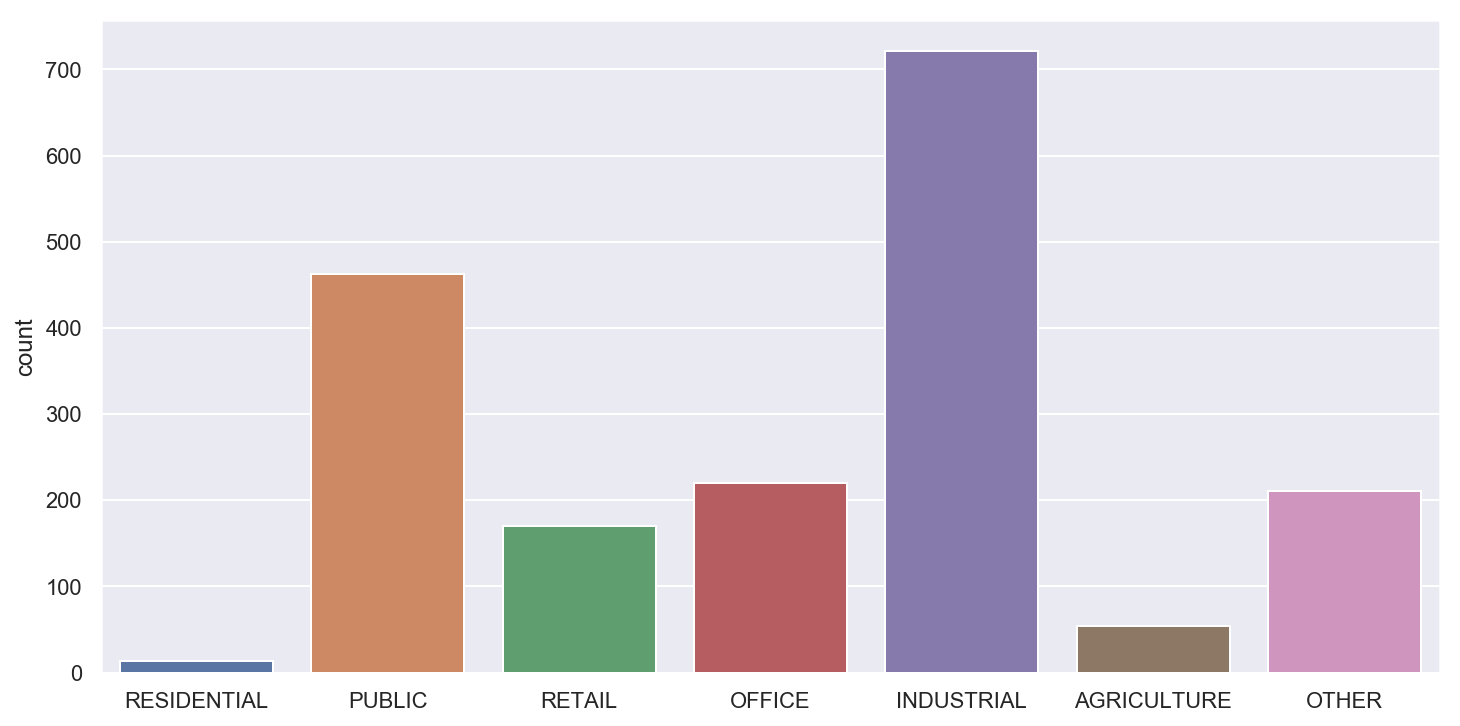

In [102]:
plt.figure(figsize=(12,6))
sns.countplot(y_pred_multi, order=list_class_order);

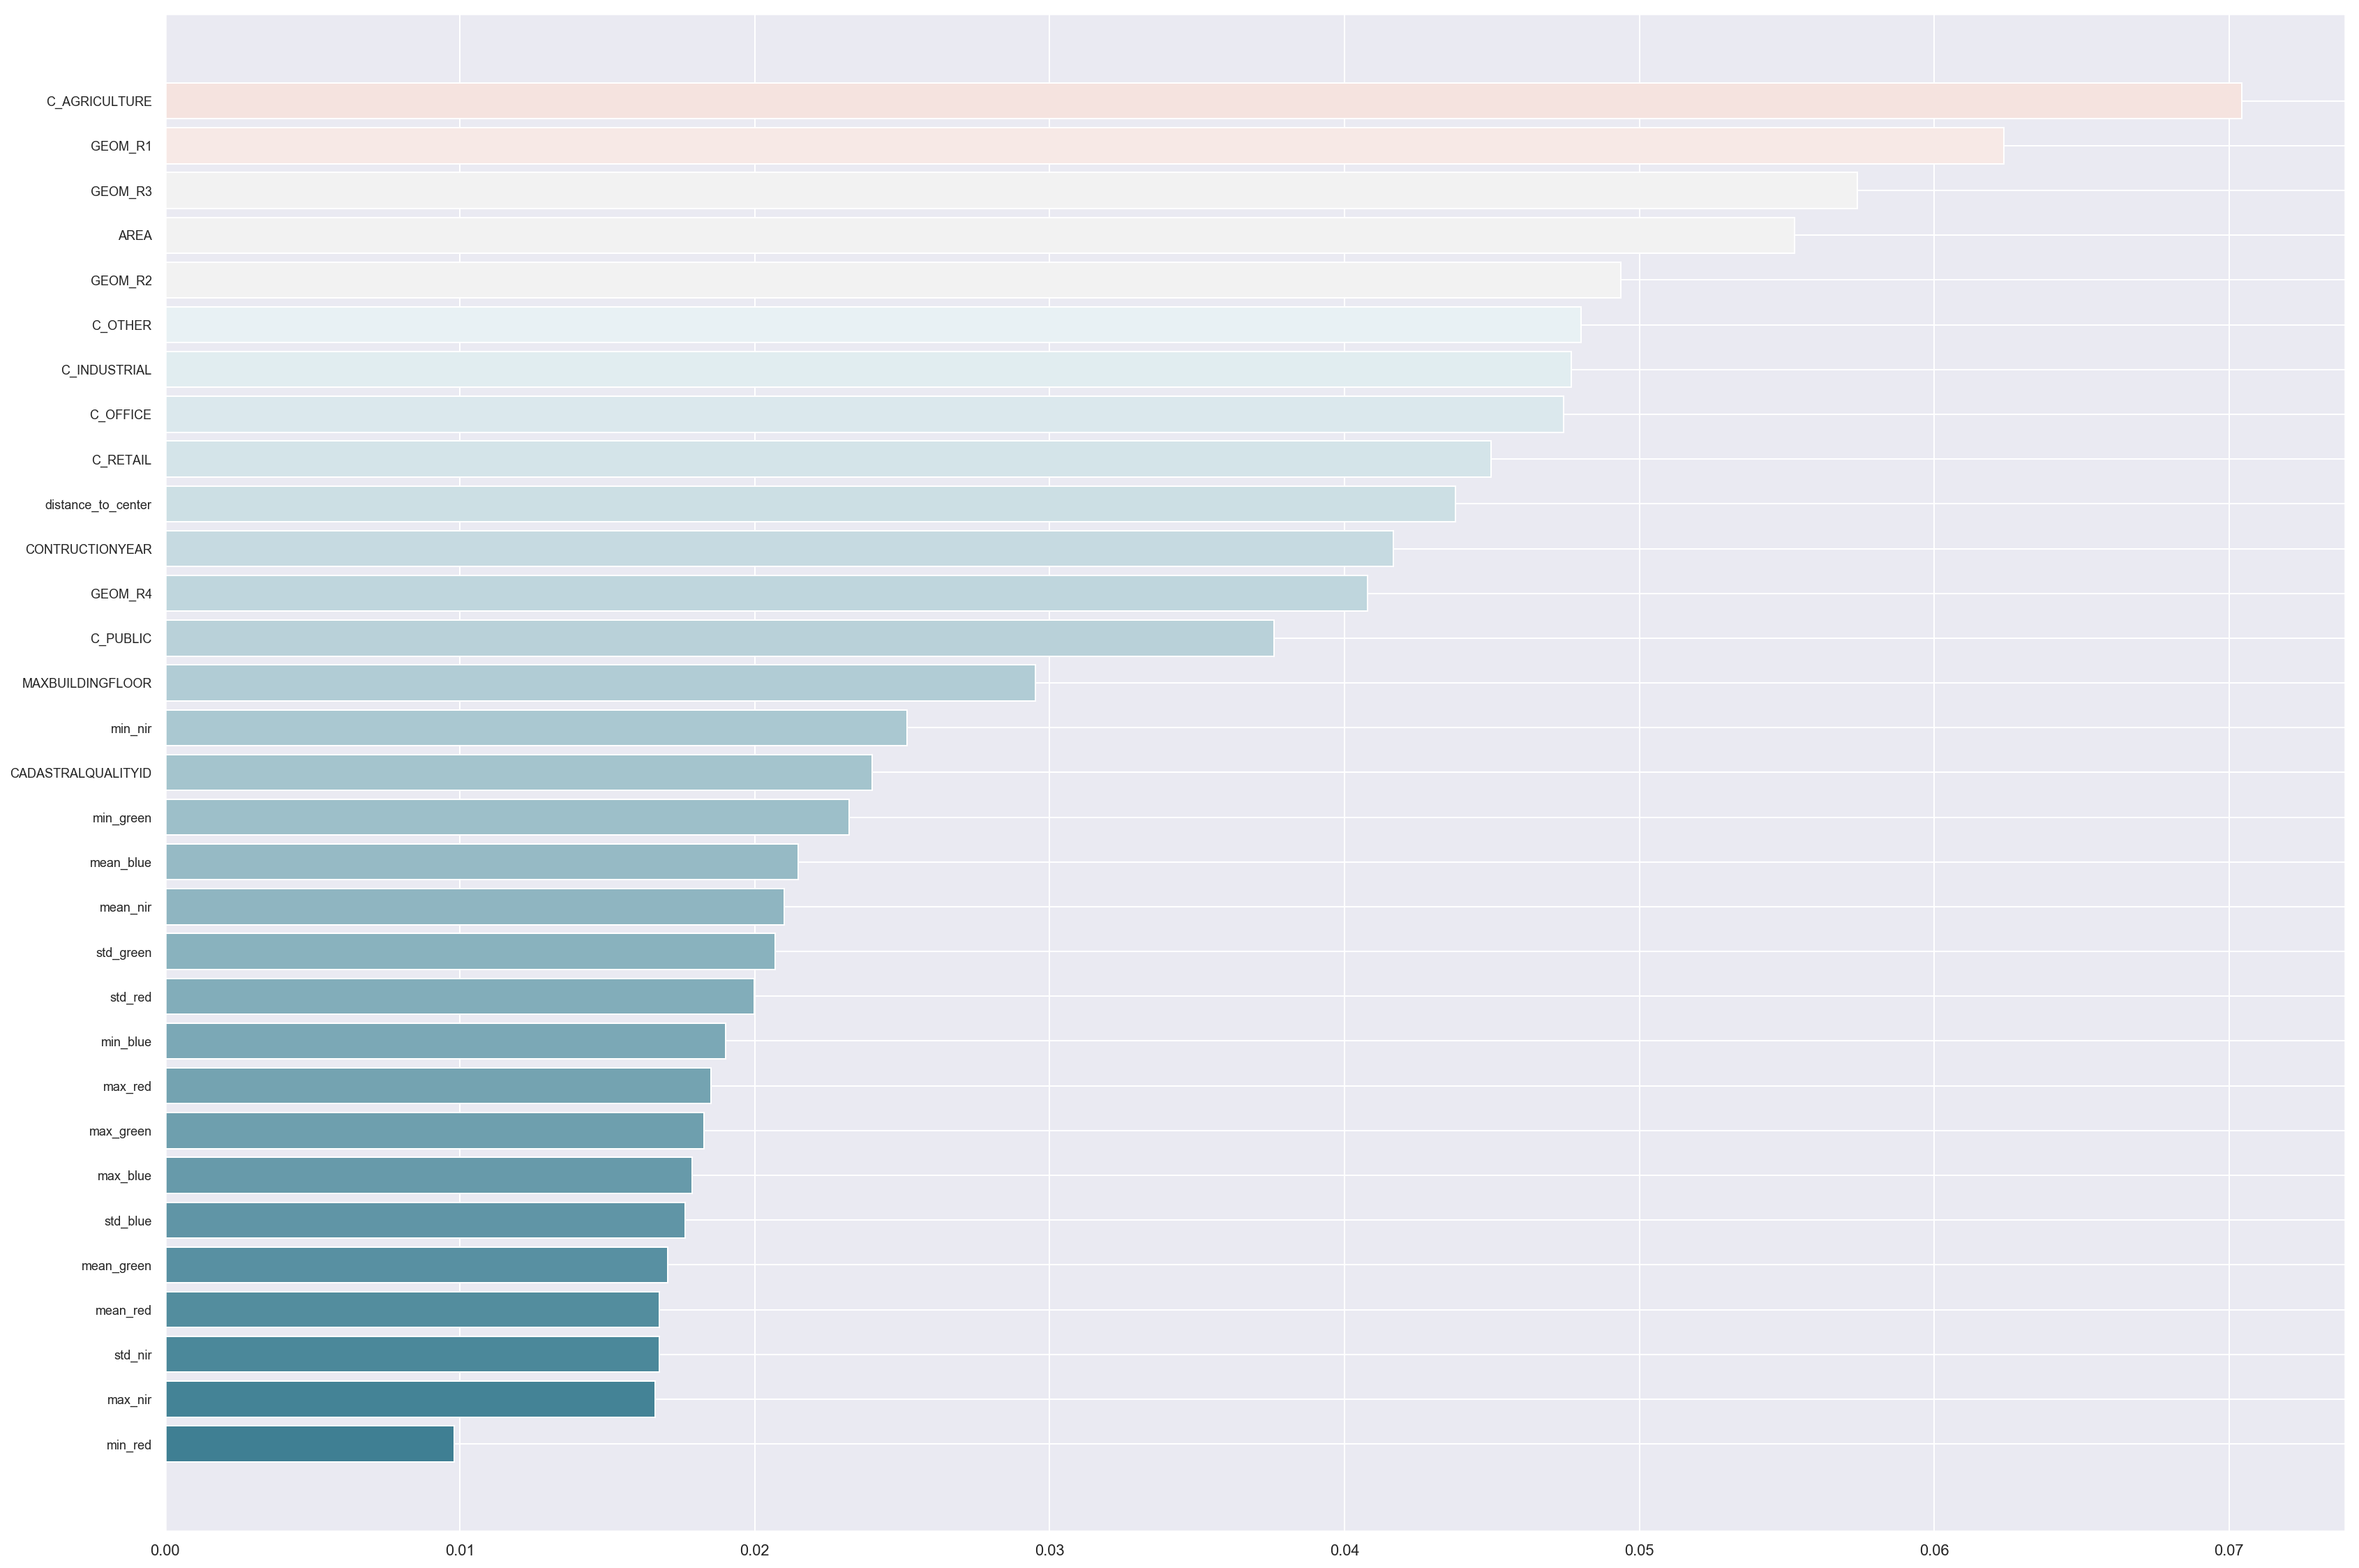

In [103]:
importances = model_multilabel['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X_test.columns[ranking], fontsize=9)
plt.show()

In [104]:
import pickle
pickle.dump(model_multilabel, open('multilabel_rfc_CCG.model', 'wb'))